# Evaluating Denoising Efficiency

## Introduction 

This notebook demonstrates how the simulated image quality phantoms generated in [the first demo notebook](00_running_simulations.ipynb) can be used to evaluate pediatric generalizability of CT denoising models. Pediatric generalizability refers to how well a model performs across pediatric subgroups, please see [Nelson et al., 2023](https://onlinelibrary.wiley.com/doi/abs/10.1002/mp.16901) for more.

| Subgroup   | Age Range                     | Waist Diameter Range          |
|------------|-------------------------------|-------------------------------|
| Newborn    | ≤ 1 mo                        | ≤ 11.5 cm                     |
| Infant     | &gt;  1 mo &amp; &lt; 2 yrs   | &gt; 11.5 cm &amp; ≤ 16.8 cm  |
| Child      | &gt; 2 yrs &amp; ≤ 12 yrs     | &gt; 16.8 cm &amp; ≤ 23.2 cm  |
| Adolescent | &gt; 12 yrs &amp; &lt; 21 yrs | &gt; 23.2 cm &amp; &lt; 34 cm |
| Adult      | ≥ 22 yrs                      | ≥ 34 cm                  

Pediatric subgroups investigated defined by age range (Source: [Guidance on Premarket Assessment of Pediatric Medical Devices](https://www.fda.gov/regulatory-information/search-fda-guidance-documents/premarket-assessment-pediatric-medical-devices)) with representative effective waist diameters ([AAPM Task Group 220](https://www.aapm.org/pubs/reports/detail.asp?docid=146)). level

## Noise Reduction in Uniform Phantoms

This notebook focuses on how to use the uniform water phantom (similar to the CTP486 module of the [Catphan 600 phantom](https://www.phantomlab.com/catphan-600)) to evaluate noise reduction efficiency.

Here noise is defined as local pixel standard deviation $\sigma$ in a uniform region:

$$
\sigma = \sqrt{\frac{1}{N} \sum_{i=1}^N (x_i' - \mu)^2},\text{ where } \mu = \frac{1}{N} \sum_{i=1}^N x'_i \text{ for each pixel } x_i
$$

We can thus define noise reduction relative to the input FBP image as:

$$
\text{Noise Reduction} = 100\% \times \frac{(\text{FBP} - \text{denoised})}{\text{FBP}}
$$

For the purposes of demonstration, this notebook compares a pretrained deep learning denoising model based on a RED-CNN architecture to compare against a baseline FBP image series. To do this a few more libraries need to be installed to load and run the model ([Torchvision](https://pytorch.org/vision/stable/index.html)) and to visualize the results ([Matplotlib](https://matplotlib.org/) and [Seaborn](https://seaborn.pydata.org/))

In [1]:
!pip install torchvision -q
!pip install seaborn -q
!pip install matplotlib -q

The following cell loads the necesarry libraries and downloads the pregenerated dataset from [Zenodo](https://zenodo.org/doi/10.5281/zenodo.10064035). Note, you can replace the value of `base_dir` with the path of your simulation results from [the first demo notebook](00_running_simulations.ipynb) or from running the [command line function](https://pediatriciqphantoms.readthedocs.io/en/latest/usage.html#command-line-interface), so long as the path contains the `metadata.csv` file which containing the file paths and file metadata summaries.

In [2]:
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import pydicom
from torchvision.datasets.utils import download_and_extract_archive

base_dir = Path('data')

if not base_dir.exists():
    url ='https://zenodo.org/records/11267694/files/pediatricIQphantoms.zip'
    download_and_extract_archive(url, download_root=base_dir)
base_dir = base_dir / 'pediatricIQphantoms'

One important detail when loading `metadata.csv` is that file paths under the file column are *relative* which means the dataset can be moved without breaking file paths. However, some functions require absolute file paths, these can be added usins the `apply` method on the dataframe column (3rd line in the cell below and copied here for reference):

```python
meta.file = meta.file.apply(lambda o: base_dir.absolute() / o)
```

In [3]:
meta = pd.read_csv(base_dir / 'metadata.csv')
meta = meta[meta.phantom == 'uniform']
meta.file = meta.file.apply(lambda o: base_dir.absolute() / o)
meta.head()

,Name,effective diameter [cm],age [year],pediatric subgroup,phantom,scanner,Dose [%],recon,kernel,FOV [cm],file,patientid,studyid,series,repeat
3544,11.2 cm uniform,11.2,0.083333,newborn,uniform,Siemens Somatom Definition,25.0,fbp,D45,12.0,/home/brandon.nelson/Dev/Regulatory_Science_To...,16.0,64,simulation,0
3545,11.2 cm uniform,11.2,0.083333,newborn,uniform,Siemens Somatom Definition,25.0,fbp,D45,12.0,/home/brandon.nelson/Dev/Regulatory_Science_To...,16.0,64,simulation,1
3546,11.2 cm uniform,11.2,0.083333,newborn,uniform,Siemens Somatom Definition,25.0,fbp,D45,12.0,/home/brandon.nelson/Dev/Regulatory_Science_To...,16.0,64,simulation,2
3547,11.2 cm uniform,11.2,0.083333,newborn,uniform,Siemens Somatom Definition,25.0,fbp,D45,12.0,/home/brandon.nelson/Dev/Regulatory_Science_To...,16.0,64,simulation,3
3548,11.2 cm uniform,11.2,0.083333,newborn,uniform,Siemens Somatom Definition,25.0,fbp,D45,12.0,/home/brandon.nelson/Dev/Regulatory_Science_To...,16.0,64,simulation,4


In [4]:
sorted(meta['FOV [cm]'].unique())

[12.0, 14.0, 17.0, 20.0, 24.0, 32.0, 34.0, 39.0]

The notebook `utils` folder contains a couple of useful visualization functions, `browse_functions` for static image viewing and `study_viewer` provides an interactive widget

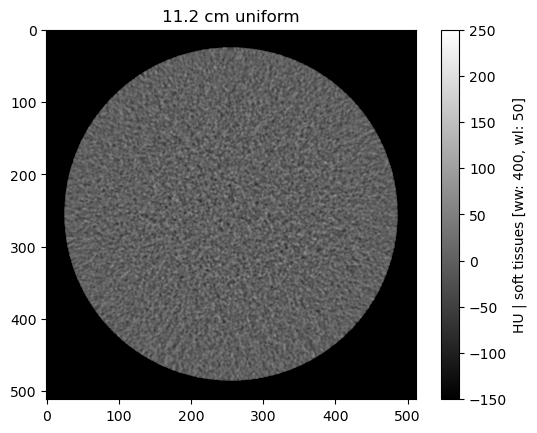

In [5]:
from utils import browse_studies, study_viewer
browse_studies(meta, phantom='uniform', fov=12, dose=100, recon='fbp')

In [6]:
study_viewer(meta)

interactive(children=(Dropdown(description='phantom', options=('uniform',), value='uniform'), Dropdown(descrip…

## Apply a denoiser

The following loads a pretrained [RED-CNN implementation](https://github.com/SSinyu/RED-CNN) and uses it to process the phantom test series and compare denoising performance to the FBP inputs.

In [7]:
import sys
import os
import torch
from denoising.networks import RED_CNN

def read_dicom(dcm_file):
    dcm = pydicom.read_file(dcm_file)
    return dcm.pixel_array + float(dcm.RescaleIntercept)

def load_model(save_path, iter_=13000, device='cpu'):
    REDCNN = RED_CNN()
    f = os.path.join(save_path, 'REDCNN_{}iter.ckpt'.format(iter_))
    REDCNN.load_state_dict(torch.load(f, map_location=device))
    return REDCNN

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
denoising_model  = load_model('denoising/models/redcnn', device=device)

/home/brandon.nelson/miniconda3/envs/pediatricIQphantoms/lib/python3.12/site-packages/torch/cuda/__init__.py:118: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


`studyid` is a useful tag for grouping all of the repeats or slices of the same phantom under different conditions, thus all of the files under a single `studyid` can be loaded into a volume for easier analysis

In [8]:
meta.studyid.unique()

array([64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80,
       81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95])

In [9]:
vol = np.array([read_dicom(o) for o in meta[meta['studyid'] == 64].file])
vol.shape

(200, 512, 512)

In [10]:

denoising_model.to(device)
batch_size = 32 #play around with an inference batch size that fits on your gpu

denoised = denoising_model.predict(vol[:, None], device=device, batch_size=batch_size)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [04:39<00:00, 39.94s/it]


You could just apply the denoiser to each row individually, that would not be an efficient use of the gpu which work well with mini batches (if using a gpu, if using cpu it shouldn't matter), this is another benefit of grouping by `studyid` and loading as a volume rather than single slices.

The following cell groups volumes by studyid for more efficient processing and adds their filenames and associated metadata to a new metadata dataframe called `results`

In [11]:
rows = []
count = 0
studyids = meta[(meta['Dose [%]'] == 25)].studyid.unique()
for study in studyids:
    print(f'denoising batch: {count}/{len(studyids)}')
    vol = np.array([read_dicom(o) for o in meta[meta['studyid'] == study].file])
    denoised = denoising_model.predict(vol[:, None], device=device, batch_size=batch_size) # replace with your own model here <--
    # save result
    slice_idx = 0
    for idx, row in meta[meta['studyid'] == study].iterrows():
        rows.append(pd.DataFrame(row).T)
        new_row = row.copy()

        dcm = pydicom.read_file(row.file)
        new_row.recon = 'RED-CNN'
        dcm.ConvolutionKernel = new_row.recon
        dcm.PixelData = denoised[slice_idx].astype('int16') - int(dcm.RescaleIntercept)
        slice_idx += 1
        save_file = Path(str(row.file).replace('fbp', new_row.recon))
        save_file.parent.mkdir(exist_ok=True, parents=True)
        pydicom.write_file(save_file, dcm)

        new_row.file = save_file
        rows.append(pd.DataFrame(new_row).T)
    count += 1
results = pd.concat(rows, ignore_index=True)

denoising batch: 0/8


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [04:30<00:00, 38.59s/it]


denoising batch: 1/8


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [04:23<00:00, 37.65s/it]


denoising batch: 2/8


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [04:30<00:00, 38.60s/it]


denoising batch: 3/8


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [04:22<00:00, 37.53s/it]


denoising batch: 4/8


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [04:19<00:00, 37.08s/it]


denoising batch: 5/8


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [04:21<00:00, 37.32s/it]


denoising batch: 6/8


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [04:22<00:00, 37.50s/it]


denoising batch: 7/8


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [04:22<00:00, 37.54s/it]


In [12]:
results.head()

,Name,effective diameter [cm],age [year],pediatric subgroup,phantom,scanner,Dose [%],recon,kernel,FOV [cm],file,patientid,studyid,series,repeat
0,11.2 cm uniform,11.2,0.083333,newborn,uniform,Siemens Somatom Definition,25.0,fbp,D45,12.0,/home/brandon.nelson/Dev/Regulatory_Science_To...,16.0,64,simulation,0
1,11.2 cm uniform,11.2,0.083333,newborn,uniform,Siemens Somatom Definition,25.0,RED-CNN,D45,12.0,/home/brandon.nelson/Dev/Regulatory_Science_To...,16.0,64,simulation,0
2,11.2 cm uniform,11.2,0.083333,newborn,uniform,Siemens Somatom Definition,25.0,fbp,D45,12.0,/home/brandon.nelson/Dev/Regulatory_Science_To...,16.0,64,simulation,1
3,11.2 cm uniform,11.2,0.083333,newborn,uniform,Siemens Somatom Definition,25.0,RED-CNN,D45,12.0,/home/brandon.nelson/Dev/Regulatory_Science_To...,16.0,64,simulation,1
4,11.2 cm uniform,11.2,0.083333,newborn,uniform,Siemens Somatom Definition,25.0,fbp,D45,12.0,/home/brandon.nelson/Dev/Regulatory_Science_To...,16.0,64,simulation,2


## Visualizing the Results

We can use the `results` csv similar to `meta` to visualize the new image series which include the RED-CNN processed results

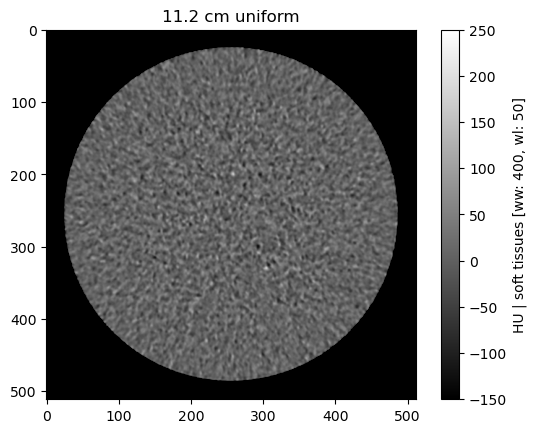

In [13]:
browse_studies(results, phantom='uniform', fov=12, dose=25, recon='RED-CNN')

In [14]:
study_viewer(results)

interactive(children=(Dropdown(description='phantom', options=('uniform',), value='uniform'), Dropdown(descrip…

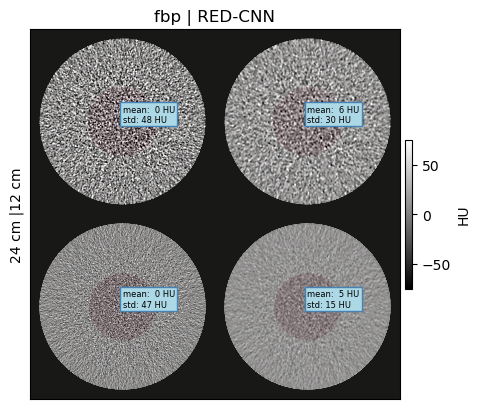

In [15]:
from utils import make_montage
make_montage(results, roi_diameter=0.4, fovs=[12, 24], wwwl=(150, 0))

## Assessing Noise Reduction

In [16]:
from utils import measure_roi_std
%timeit measure_roi_std(results.file.iloc[1])

36.8 ms ± 1.93 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


This takes about 1-2 min to make all of the noise measurements across 3200 images

In [17]:
results['noise std [HU]'] = results.file.apply(measure_roi_std)

<Axes: xlabel='FOV [cm]', ylabel='noise std [HU]'>

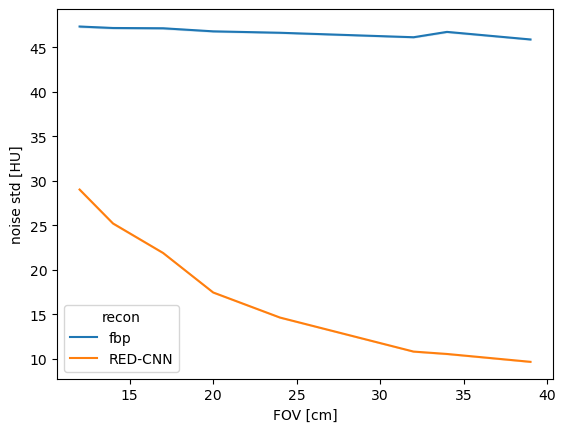

In [18]:
import seaborn as sns
sns.lineplot(data=results, x='FOV [cm]', y='noise std [HU]', hue='recon')

The RED-CNN model we evaluated was trained on an adult dataset of large fields of view (FOV) thus the above results show the lowest noise levels in the larger FOVs most similar to the training set. We can calculate this as a noise reduction as described previously

$$\text{Noise Reduction} = 100\% \times \frac{(\text{FBP} - \text{denoised})}{\text{FBP}}$$

To get the following curve of noise reduction performance as a function of FOV.

In [19]:
from utils import calculate_noise_reduction

In [20]:
results = calculate_noise_reduction(results)

<Axes: xlabel='FOV [cm]', ylabel='noise std [HU] reduction [%]'>

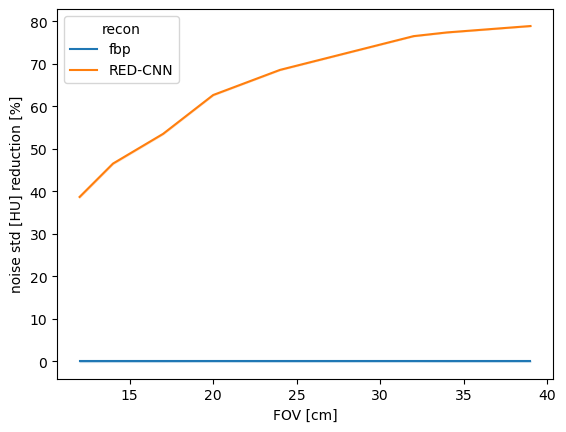

In [21]:
sns.lineplot(data=results, x='FOV [cm]', y='noise std [HU] reduction [%]', hue='recon')

Keep in mind that abdominal imaging protocols typically use body fitting FOVs, thus for smaller patients including pediatric patients, this poorer performance in small FOVs translates to poorer performance in pediatric patients.

To this end we can rebin our results based on the pediatric subgroups define previously, here they are again plotted for comparison:

Text(0, 0.5, 'Mean Effective Diameter [cm]')

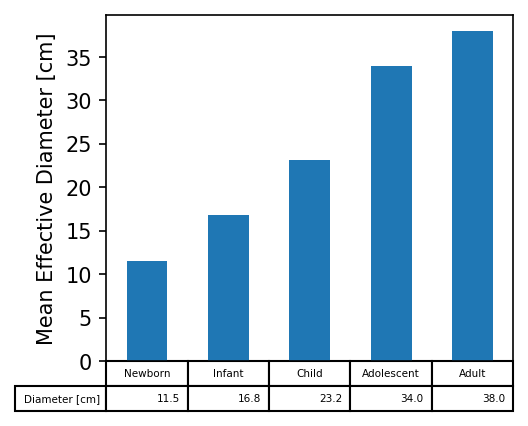

In [22]:
df = pd.DataFrame({'Subgroup': ['Newborn', 'Infant', 'Child', 'Adolescent', 'Adult'],
                   'Diameter [cm]':[11.5, 16.8, 23.2, 34, 38],
                   'Age [yrs]': [0, 2, 12, 21, 38]})
f, ax=plt.subplots(figsize=(3.5,3), dpi=150)
df.plot.bar(ax=ax, x='Subgroup',y='Diameter [cm]', table=True, legend=False)
ax.get_xaxis().set_visible(False)
ax.set_ylabel('Mean Effective Diameter [cm]')

Below we can compare noise reduction performance as a function of pediatric subgroup following the binning of patient size into these subgroups and see that performance is best in adults and adolescents which better represent the adult training dataset, the [Mayo Clinic Low Dose Grand Challenge Dataset](https://aapm.onlinelibrary.wiley.com/doi/full/10.1002/mp.12345)

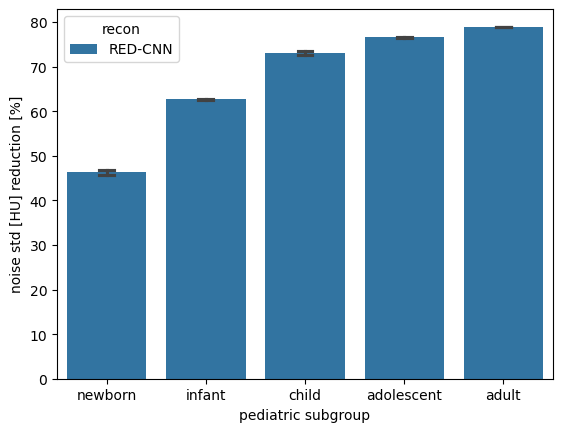

In [23]:
f, ax = plt.subplots()
sns.barplot(data=results[results.recon != 'fbp'], x='pediatric subgroup', y='noise std [HU] reduction [%]', hue='recon', capsize=0.15, ax=ax)
f.savefig('../pediatric_subgroup_performance.png', dpi=300)

## Conclusions

Noise reduction is but one of several factors to consider when assessing image quality of CT reconstructions and denoising algorithms, for more information on image quality assessments to justify dose reduction please see [Vaishnav 2018](https://aapm.onlinelibrary.wiley.com/doi/full/10.1118/1.4881148). For a review of unique considerations for dose reduction with AI reconstruction and denoising please see [Brady 2023](https://academic.oup.com/bjr/article/96/1150/20220915/7498930). 

This concludes our worked examples. Next you can refer to the [API guide](https://pediatriciqphantoms.readthedocs.io/en/latest/function_reference.html) for more detailed function documentation or [consider contributing the package](https://pediatriciqphantoms.readthedocs.io/en/latest/contributing.html).

**Further Steps**

These notebooks have provided simple examples for generating CT datasets representative of pediatric-sized patients with flexibility to simulate a range of x-ray dose and system parameters. Next you are encouraged to explore other tools for assessing task-based image quality using the [Low Contrast Detectability for CT Toolbox](https://github.com/DIDSR/LCD_CT) which is compatible with the MITA-LCD images made available in [pediatricIQphantoms](https://github.com/DIDSR/pediatricIQphantoms)